# **BERTopic for policies analysis**

In [1]:
%%capture

#!pip install safetensors
#%pip install datasets
#%pip install datashader
#%pip install adjustText

In [1]:
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from datasets import load_dataset

/home/mnikiema/OpenSource/13_democratiser_sobriete/policy_analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk

try:
    stopword = stopwords.words('english')
except LookupError:
    print('Downloading stopwords...')
    nltk.download('stopwords')
    stopword = stopwords.words('english')

In [ ]:
dataset_name = "EdouardCallet/wsl-policy-10k"
dataset_split = "train"
dataset = load_dataset(dataset_name, split=dataset_split)
text_field = "single_policy_item"
dataset = dataset.filter(lambda example: bool(example[text_field]))
df: pd.DataFrame = dataset.select_columns([text_field]).to_pandas()
print(df.shape)
df.head()

(10122, 1)


,text
0,RESULTS\nGermplasm accessions had variability...
1,ness deviation\nInformation: |loading| ≥ 0.4 w...
2,\nLWR\nWD\nT\nMD\nAC\nGT\nGC\nSD\nLoading valu...
3,"548, 10591, 10474, dan 10550. For developing l..."
4,RESULTS\nConceptualizing Stress and Work Over...


In [ ]:
print(df.isna().sum())
df = df.dropna()

## Embeddings

- Nous pré-calculerons et sauvegarderons les embeddings pour le modèle BERTopic
- Cela nous permet de gagner du temps en évitant cette étape lors des itérations futures sur le modèle.

In [4]:
Embeddings = "Qwen/Qwen3-Embedding-0.6B"

In [5]:
# Creation des embeddings
model = SentenceTransformer(Embeddings)

Il est recommendé de sauvegarder les embeddings pour ne pas les calculer tout temps:

In [6]:
from sklearn.preprocessing import Normalizer
dataset.set_format(type="numpy", columns=["embedding"])
embeddings = np.array(dataset["embedding"])

embeddings = Normalizer().fit_transform(embeddings)

In [ ]:
# with open('./embeddings.npy', 'wb') as f:
#     np.save(f, embeddings)

- On peut les charger en mémoire comme suit:

## Preparation du vocabulaire

L'auteur suggère de préparer le vocabulaire en amont pour économiser de la mémoire avant d'entraîner leur modèle.

Cette étape, bien que facultative avec assez de RAM, peut aider à réduire son utilisation. 

Il recommande aussi d'utiliser un `CountVectorizer` personnalisé plutôt que le `CountVectorizer` par défaut, s'il est disponible.

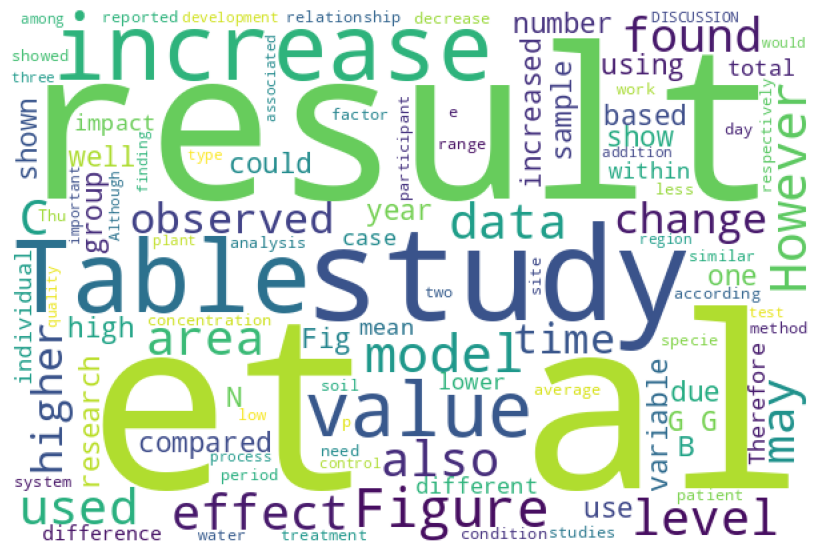

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = " ".join(df[text_field].tolist())

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Construction du vocabulaire
all_vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(df[text_field].tolist()):
  all_vocab.update(tokenizer(doc))

100%|██████████| 10122/10122 [00:01<00:00, 6106.20it/s]


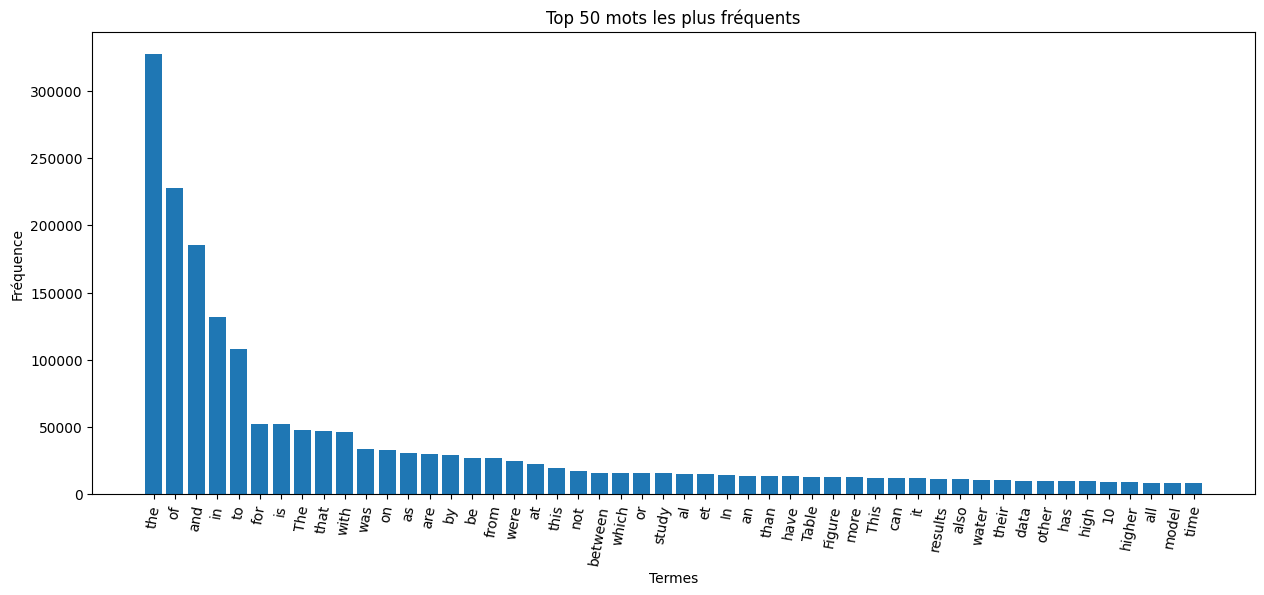

In [ ]:
import matplotlib.pyplot as plt

top_n = 50
most_common_words = all_vocab.most_common(top_n)

# Separate the words and their frequencies
words, frequencies = zip(*most_common_words, strict=True)

# Create a bar plot

plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel('Termes')
plt.ylabel('Fréquence')
plt.title('Top ' + str(top_n) +' mots les plus fréquents')
plt.xticks(rotation=80)
plt.show()

- On peut ainsi voir le nombre de mots dans notre vocabulaire

In [13]:
vocab = [word for word, frequency in all_vocab.items() if word.lower() not in stopword]

In [14]:
len(vocab)

137872

## Entrainement de `BERTopic`

Nous pouvons entraîner notre modèle `BERTopic`.

Nous sélectionnons un modèle d'embeddings de phrases de la librairie SentenceTransformer et nous choisissons les modèles `HDBSCAN` et `UMAP`. 

Nvidia a développé des versions accélérées par GPU de `HDBSCAN` et `UMAP`, ce qui permet d'améliorer l'entraînement sur un ensemble de données aussi volumineux.

In [ ]:
from umap import UMAP
import hdbscan
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

# Preparation des modèles

#
embedding_model = SentenceTransformer(Embeddings)
# UMAP
umap_model = UMAP(n_components=8, n_neighbors=10, random_state=42,
                  metric="cosine", verbose=True)
# HDBSCAN
hdbscan_model = KMeans(n_clusters=200, random_state=42, max_iter=800)
# Vectorizer
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True,
        representation_model= MaximalMarginalRelevance(diversity=0.3),
).fit(df[text_field].tolist(), embeddings=embeddings)

Nous pouvons examiner les sujets comme suit :

In [15]:
topic_info = topic_model.get_topic_info()

In [16]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,714,-1_emission_risk_project_waste,"[emission, risk, project, waste, zakat, touris...",[property/structure buyout and habitat restora...
1,0,55,0_modeling_stochastic_fuzzy_networks,"[modeling, stochastic, fuzzy, networks, optimi...","[process modeling methodology, process modelin..."
2,1,52,1_coal_fueled_severance_ash,"[coal, fueled, severance, ash, taxes, states, ...","[coal, coal, coal]"
3,2,45,2_physical_habitual_exercise_questionnaire,"[physical, habitual, exercise, questionnaire, ...","[physical activity, physical activity, physica..."
4,3,39,3_organic_rotations_varieties_cotton,"[organic, rotations, varieties, cotton, crop, ...","[organic farming, organic farming, organic far..."
...,...,...,...,...,...
336,335,6,335_parking_stations_bus_stadia,"[parking, stations, bus, stadia, exits, headwa...",[average bus headway in the station catchment ...
337,336,5,336_perfection_investment_agreement_regional,"[perfection, investment, agreement, regional, ...","[Fjarrkyla Invest 60 agreement, perfection of ..."
338,337,5,337_combustion_pyrolysis_direct_advanced,"[combustion, pyrolysis, direct, advanced, gasi...","[advanced combustion control, combustion of by..."
339,338,5,338_aggregates_aggregate_sizes_larger,"[aggregates, aggregate, sizes, larger, aggrega...","[using other aggregates, larger aggregate size..."


Metrics to evaluate topic modelling:

- Coherence: The coherence of a topic is the average similarity between words in the topic.
- Diversity: The diversity is the proportion of unique topics words.

All these metrics is less than 1. 

In [ ]:
# from octis.evaluation_metrics.coherence_metrics import Coherence
# from octis.evaluation_metrics.diversity_metrics import TopicDiversity

# from typing import TypedDict, List
# from functools import partial


# class TopicInfo(TypedDict):
#     topics: List[List[str]]
#     docs: List[List[str]]


# class EvalScore(TypedDict):
#     coherence_npmi: float
#     coherence_cv: float
#     diversity: float



# def evaluator(topics: TopicInfo, topk: int = 10) -> EvalScore:
#     partial_coherence = partial(Coherence, texts=topics["docs"], topk=topk)
#     coherence_npmi = partial_coherence().score(topics)
#     coherence_cv = partial_coherence(measure="c_v").score(topics)
#     diversity = TopicDiversity().score(model_output=topics)
#     return EvalScore(coherence_cv=coherence_cv, coherence_npmi=coherence_npmi,
#                      diversity=diversity)

# topics = topic_info[topic_info["Topic"] != -1]["Topic"]
# topic_list = []
# for topic in topics:
#     topic = topic_model.get_topic(topic)
#     topic_list.append([word[0] for word in topic])

# topic_inf = TopicInfo(topics=topic_list, docs=[doc.split() for doc in docs])

# eval_res = evaluator(topic_inf)
# eval_res

In [17]:
topics_docs = topic_info[topic_info["Topic"] != -1]["Representative_Docs"]

## Visualisation des thèmes
### Diagramme en barre

In [29]:
topic_model.visualize_barchart(top_n_topics=40, n_words=10)

### Visualiser la hiérarchie des thèmes

- Certaines thématiques sont en fait des sous-thèmes d'autres thématiques.
- Comprendre la hiérarchie permet de déterminer quelles thématiques devraient être fusionnées et lesquelles ne le devraient pas.

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(df[text_field].tolist())

100%|██████████| 339/339 [00:04<00:00, 81.24it/s]


In [23]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
def fit_bertopic_model(docs=df[text_field].tolist(), embeddings=embeddings, vocab=vocab, stopword=stopword, 
                       embedding_model_name=Embeddings, representation_model=None, y=None):
    """
    Fits a BERTopic model with custom configurations.

    :param docs: List of documents to fit the model.
    :param embeddings: Pre-computed embeddings for the documents.
    :param vocab: Vocabulary for the CountVectorizer.
    :param stopword: List of stopwords.
    :param embedding_model_name_or_instance: The name of the embedding model or an already initialized model instance.
    :return: Fitted BERTopic model.
    """
    # Load or use the provided sentence transformer model
    
    embedding_model = SentenceTransformer(embedding_model_name)

    # Initialize UMAP
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42,
                      metric="euclidean", verbose=True)

    # Initialize HDBSCAN
    hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                    prediction_data=True, min_cluster_size=20)

    # Initialize CountVectorizer
    vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

    # Fit BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True,
        representation_model=representation_model
    ).fit(docs, embeddings=embeddings)

    return topic_model


Enfin, on sauvegarder le modèle de la manière suivante :

In [33]:
topic_model.save(
    path='./models/bert_topic_model',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model=True,
)

De même, nous pouvons également préparer les embeddings réduits par `UMAP` pour la visualisation de documents en 2D:

In [25]:
from umap import UMAP

# On applique ici une réduction de dimension avec une sortie de dimension 2
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42,
                  metric="cosine", verbose=True)

reduced_embeddings_2d = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Fri Oct 31 10:25:50 2025 Construct fuzzy simplicial set
Fri Oct 31 10:25:50 2025 Finding Nearest Neighbors
Fri Oct 31 10:25:50 2025 Building RP forest with 9 trees
Fri Oct 31 10:25:51 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	Stopping threshold met -- exiting after 6 iterations
Fri Oct 31 10:25:51 2025 Finished Nearest Neighbor Search
Fri Oct 31 10:25:51 2025 Construct embedding


Epochs completed:   4%| ▍          20/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         62/500 [00:00]

	completed  50  /  500 epochs


Epochs completed:  23%| ██▎        113/500 [00:01]

	completed  100  /  500 epochs


Epochs completed:  33%| ███▎       164/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  43%| ████▎      216/500 [00:02]

	completed  200  /  500 epochs


Epochs completed:  54%| █████▍     270/500 [00:02]

	completed  250  /  500 epochs


Epochs completed:  62%| ██████▏    312/500 [00:03]

	completed  300  /  500 epochs


Epochs completed:  73%| ███████▎   364/500 [00:03]

	completed  350  /  500 epochs


Epochs completed:  84%| ████████▎  418/500 [00:04]

	completed  400  /  500 epochs


Epochs completed:  94%| █████████▍ 471/500 [00:04]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:05]

Fri Oct 31 10:25:57 2025 Finished embedding


## Visualize Documents

In [ ]:
import itertools
import pandas as pd

# Couleurs pour la visalisation
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                           '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                           '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                           '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
                           '#ffffff', '#000000'])

color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Transformer les embeddings en dataframe
docs = df[text_field].tolist()
data = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1],
                   "Topic": [str(t) for t in topic_model.topics_]})

data["Length"] = [len(doc) for doc in docs]
data = data.loc[data.Topic != "-1"]
data = data.loc[(data.y > -10) & (data.y < 10) & (data.x < 10) & (data.x > -10), :]
data["Topic"] = data["Topic"].astype("category")

# Calculer les centroids des clusters
mean_df = data.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_data = mean_df.sort_values("Topic")

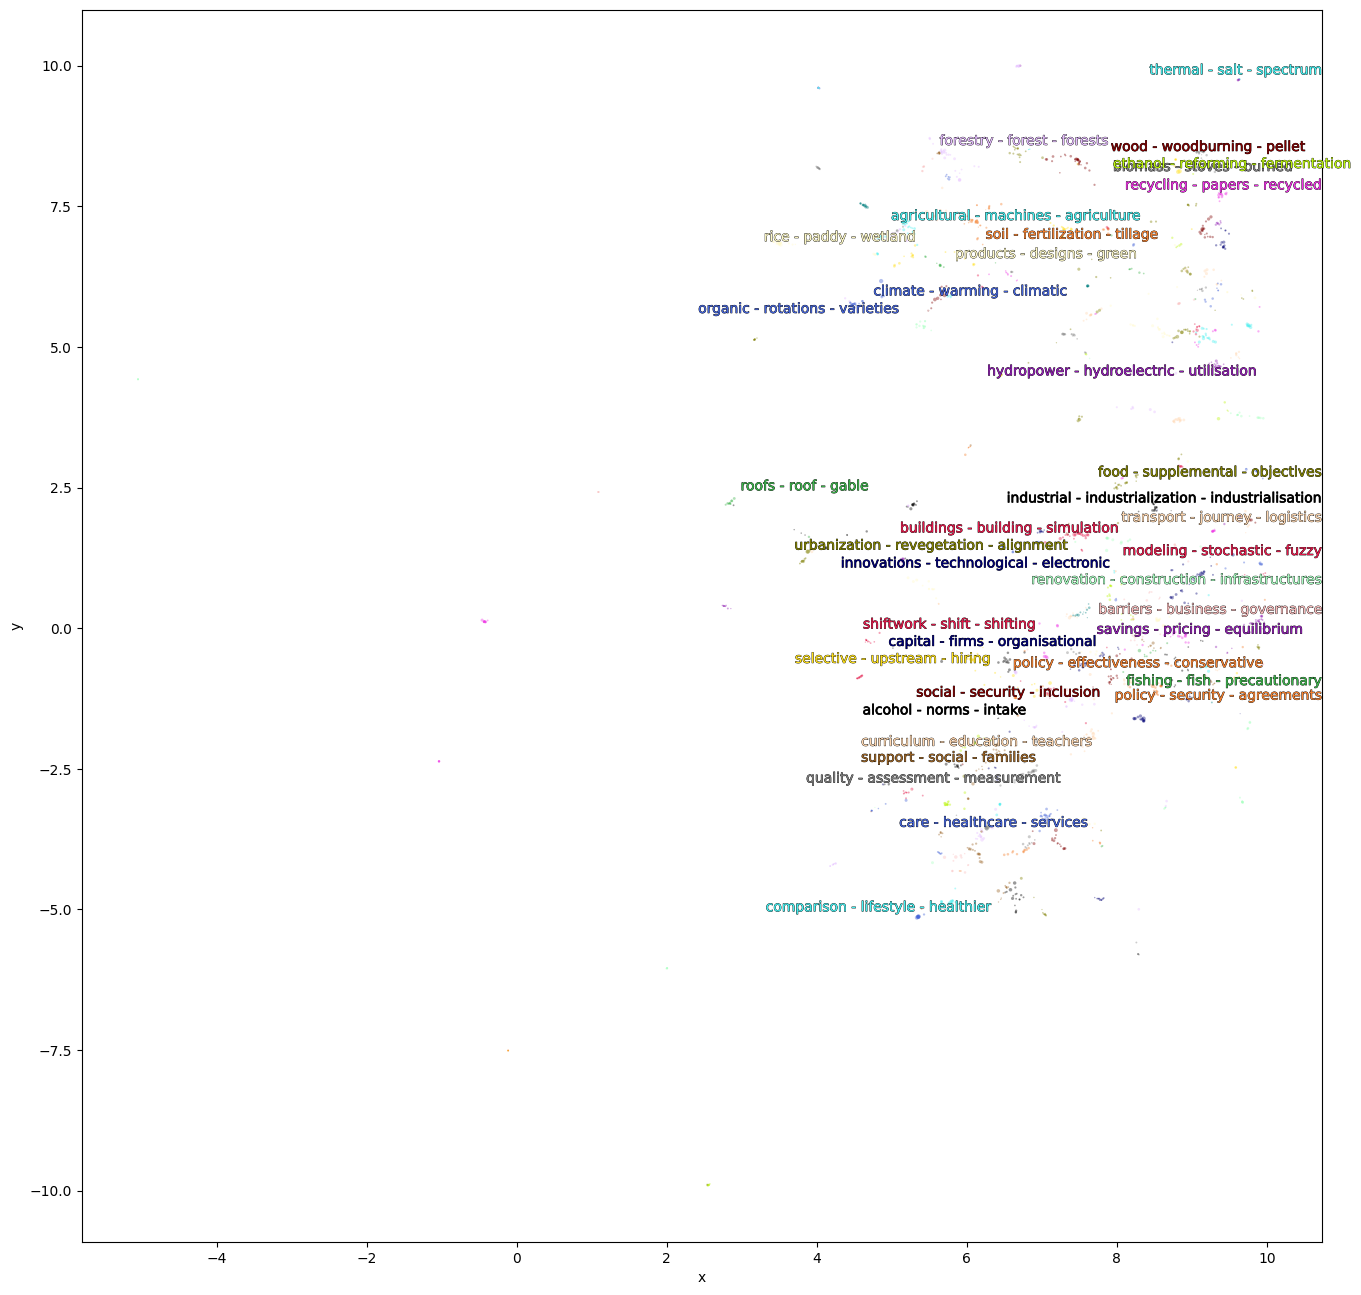

<Figure size 640x480 with 0 Axes>

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=data, x='x', y='y', hue='Topic', palette=color_key, alpha=0.4,
                sizes=(0.4, 10), size="Length", legend=False)

# Annotater les 50 premiers tthèmes
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center",
                          color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))


adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02),
            force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
plt.savefig("output.png", dpi=600)